In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scienceplots
from scipy.interpolate import interp1d
from scipy.differentiate import derivative
from scipy.optimize import root_scalar

In [2]:
plt.style.use(['science'])

## PL microlens embedded in a macrolens

In [3]:
#Defining parameters

mu_r = 3 # macro model radial magnification
mu_t = 100 # Macro model tangential magnification
time_step = 0.1
timestamps = np.arange(-50, 50, time_step) # Time range for the light curve

u_min = 0 # Minimum impact parameter
t_E = 1 # Einstein radius crossing time

In [4]:
#Defining functions

def pl_embedded_magnification_inv(tau,phi,mu_r=mu_r,mu_t=mu_t): # Inverse magnification in a macro model from an image at tau
    return (1/mu_r)*(1/mu_t) - ((1/mu_r)-(1/mu_t))*(1/tau**2)*np.cos(2*phi) - (1/tau**4)

def pl_lens_eqn(tau, u_1, u_2, mu_r=mu_r, mu_t=mu_t): # Point lens equation for image position(s) tau from source position (u_1, u_2)
    R_r = ((tau / mu_r) - (1 / tau))
    R_t = ((tau / mu_t) - (1 / tau))
    return (u_1 / R_r)**2 + (u_2 / R_t)**2 - 1  #Image positions solve this equalling zero

def source_trajectory(t, u_min=u_min, t_E=t_E): # Source position in the source plane at time t
    u1 = t / t_E
    u2 = u_min
    return u1, u2

def pl_phi_from_tau(tau, u1, u2):
    R_r = ((tau / mu_r) - (1 / tau))
    R_t = ((tau / mu_t) - (1 / tau))
    return np.arctan2(u2 / R_t, u1 / R_r)  # Calculate the angle of the image position


In [5]:
all_solutions_pl = []

for t in timestamps:

    u1, u2 = source_trajectory(t) 

    if np.abs(u1) < 0.1* time_step / t_E and u2 == 0:
        special_solutions = [(np.sqrt(mu_r), 0), (np.sqrt(mu_r), np.pi), (np.sqrt(mu_t), np.pi/2), (np.sqrt(mu_t), 3*np.pi/2)]
        all_solutions_pl.append((special_solutions, 0))  # If the source is at the origin, the images are at the Einstein radii
    else:
        pl_tau_values = np.linspace(0.001, 1000, 10000)

        pl_lens_eqn_vals = pl_lens_eqn(pl_tau_values, u1, u2) # Evaluate the lens equation for image radial coordinate(s)

        pl_roots = []

        for i in range(len(pl_tau_values) - 1):
            if pl_lens_eqn_vals[i] * pl_lens_eqn_vals[i+1] < 0:
                a, b = pl_tau_values[i], pl_tau_values[i+1]
                sol = root_scalar(pl_lens_eqn, args=(u1,u2), bracket=[a, b], method='brentq')
                if sol.converged:
                    root_and_phi = (sol.root, pl_phi_from_tau(sol.root, u1, u2))
                    pl_roots.append(root_and_phi)

        all_solutions_pl.append((pl_roots, t)) 

all_solutions_pl

[([(0.01999733404421639, np.float64(-0.0)),
   (150.0199973340442, np.float64(3.141592653589793))],
  np.float64(-50.0)),
 ([(0.020037398147473188, np.float64(-0.0)),
   (149.72003739814747, np.float64(3.141592653589793))],
  np.float64(-49.9)),
 ([(0.020077623086026765, np.float64(-0.0)),
   (149.420077623086, np.float64(3.141592653589793))],
  np.float64(-49.8)),
 ([(0.02011800983019172, np.float64(-0.0)),
   (149.12011800983018, np.float64(3.141592653589793))],
  np.float64(-49.699999999999996)),
 ([(0.020158559358102505, np.float64(-0.0)),
   (148.82015855935808, np.float64(3.141592653589793))],
  np.float64(-49.599999999999994)),
 ([(0.020199272655792334, np.float64(-0.0)),
   (148.52019927265576, np.float64(3.141592653589793))],
  np.float64(-49.49999999999999)),
 ([(0.020240150717273062, np.float64(-0.0)),
   (148.22024015071725, np.float64(3.141592653589793))],
  np.float64(-49.39999999999999)),
 ([(0.02028119454461605, np.float64(-0.0)),
   (147.9202811945446, np.float64(3.141

Text(0.5, 1.0, 'Point Lens Lightcurve')

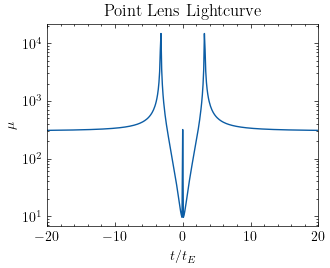

In [6]:
#calculate the magnification from the solutions found at each time t
magnifications_pl = []

for i in all_solutions_pl:
    mag_temp = []
    if len(i[0]) > 0:
        for j in i[0]:
            mag_temp.append(1/np.abs(pl_embedded_magnification_inv(j[0],j[1])))
        total_mag = np.sum(mag_temp)
        magnifications_pl.append(total_mag)

#Plot lightcurve

plt.plot(timestamps, magnifications_pl)
plt.xlabel(r'$t/t_E$')
plt.ylabel(r'$\mu$')
plt.xlim(-20,20)
# plt.ylim(0,500)
plt.yscale('log')
plt.title(r'Point Lens Lightcurve')

## Boson Star embedded in a macrolens

In [7]:
data = pd.read_csv('mt_boson_list.csv', header=None) # Load the boson star projected mass profile
data.iloc[:, 1] = data.iloc[:, 1].astype(str).str.replace(r'\*\^', 'e', regex=True).astype(float)

In [ ]:
def m(mtau, tau_m=1.0):
    mtau_cop = mtau.copy()
    
    # Scale tau values by tau_m
    mtau_cop.iloc[:, 0] = tau_m * mtau_cop.iloc[:, 0]

    # Extract columns
    tau_pos = mtau_cop.iloc[:, 0].values
    m_pos = mtau_cop.iloc[:, 1].values

    # Create symmetric negative tau values
    tau_neg = -tau_pos
    m_neg = m_pos

    # Combine: (tau, m), (-tau, m), and (0, 0)
    tau_all = np.concatenate([tau_neg, [0.0], tau_pos])
    m_all = np.concatenate([m_neg, [0.0], m_pos])

    # Sort by tau to ensure interp1d gets ordered input
    sorted_idx = np.argsort(tau_all)
    tau_sorted = tau_all[sorted_idx]
    m_sorted = m_all[sorted_idx]

    # Interpolation
    mtau_interp = interp1d(tau_sorted, m_sorted, kind='cubic', fill_value='extrapolate')
    return mtau_interp

def m_prime(m,tau):
    return derivative(m, tau, maxiter=2, order=3)

def inverse_magnification(m,tau,phi,mu_r=mu_r, mu_t=mu_t):
    return (
        (((1/mu_r) - (m_prime(m,tau).df / (2.0 * tau)) ) * ((1/mu_t) - (m_prime(m,tau).df / (2.0 * tau)) )) -
        ((m_prime(m,tau).df / (2.0 * tau)) - (m(tau) / tau**2))**2 +
        (1/mu_r - 1/mu_t) * ((m_prime(m,tau).df / (2.0 * tau)) - (m(tau) / tau**2))*np.cos(2*phi)
    )

In [14]:
def lens_eqn(tau, m_tau, u1, u2, mu_t=mu_t, mu_r=mu_r): # Embedded boson star lens equation for image position(s) tau from source position (u_1, u_2)
    R_r = ((tau / mu_r) - (m_tau(tau) / tau))
    R_t = ((tau / mu_t) - (m_tau(tau) / tau))
    return (u1 / R_r)**2 + (u2 / R_t)**2 - 1  #Image positions solve this equalling zero

def phi_from_tau(tau, m_tau, u1, u2, mu_r=mu_r, mu_t=mu_t):
    R_r = ((tau / mu_r) - (m_tau(tau) / tau))
    R_t = ((tau / mu_t) - (m_tau(tau) / tau))
    return np.arctan2(u2 / R_t, u1 / R_r)  # Calculate the angle of the image position

def special_solution_eqn_r(tau, m_tau, mu_r=mu_r): # Radial lens equation (for images at phi = 0, pi) for source at (u1,u2) = (0,0)
    return tau - np.sqrt(mu_r * m_tau(tau))

def special_solution_eqn_t(tau, m_tau, mu_t=mu_t): # Tangential lens equation (for images at phi = pi/2, 3pi/2) for source at (u1,u2) = (0,0)
    return tau - np.sqrt(mu_t * m_tau(tau))

In [15]:
tau_values = np.linspace(0.001, 1000, 10000)

# Function to solve the BS lens equation for a given tau_m over a range of timestamps
def lens_eqn_solver(tau_m, timestamps_=timestamps, tau_values_=tau_values,):
    all_solutions = []
    m_tau = m(data, tau_m)

    for t in timestamps_: 

        u1, u2 = source_trajectory(t)

        if np.abs(u1) < 0.1* time_step / t_E and u2 == 0:
            
            special_solutions = []

            special_sol_r = [special_solution_eqn_r(tau, m_tau) for tau in tau_values_]

            for i in range(len(tau_values_)-1):
                if special_sol_r[i] * special_sol_r[i+1] < 0:
                    a, b = tau_values_[i], tau_values_[i+1]
                    sol = root_scalar(special_solution_eqn_r, args=(m_tau,), bracket=[a, b], method='brentq')
                    if sol.converged:
                        special_solutions.append((sol.root, 0))
                        special_solutions.append((sol.root, np.pi))
            
            special_sol_t = [special_solution_eqn_t(tau, m_tau) for tau in tau_values_]

            for i in range(len(tau_values_)-1):
                if special_sol_t[i] * special_sol_t[i+1] < 0:
                    a, b = tau_values_[i], tau_values_[i+1]
                    sol = root_scalar(special_solution_eqn_t, args=(m_tau,), bracket=[a, b], method='brentq')
                    if sol.converged:
                        special_solutions.append((sol.root, np.pi/2))
                        special_solutions.append((sol.root, 3*np.pi/2))
            
            all_solutions.append((special_solutions, 0))

        else:

            lens_eqn_vals = [lens_eqn(tau, m_tau, u1, u2) for tau in tau_values_]
            roots = []

            for i in range(len(tau_values_) - 1):
                if lens_eqn_vals[i] * lens_eqn_vals[i+1] < 0:
                    a, b = tau_values_[i], tau_values_[i+1]
                    sol = root_scalar(lens_eqn, args=(m_tau,u1,u2), bracket=[a, b], method='brentq')
                    if sol.converged:
                        root_and_phi = (sol.root, phi_from_tau(sol.root, m_tau, u1, u2))
                        roots.append(root_and_phi)

            all_solutions.append((roots, t)) 

    return all_solutions


In [ ]:
# Function to calculate the lightcurve for the BS with given tau_m
def boson_star_lightcurve(tau_m,timestamps_=timestamps, tau_values_=tau_values):
    m_tau = m(data, tau_m)
    all_solutions = lens_eqn_solver(tau_m, timestamps_, tau_values_)
    magnifications = []

    for i in all_solutions:
        m_tau = m(data, tau_m)
        magn_temp = []
        if len(i[0]) > 0:
            for j in i[0]:
                magn_temp.append(1/np.abs(inverse_magnification(m_tau,j[0],j[1])))
        total_magn = np.sum(magn_temp)
        magnifications.append(total_magn)
    
    return magnifications

In [ ]:
magnifications_tm_10 = boson_star_lightcurve(10)
magnifications_tm_20 = boson_star_lightcurve(20)

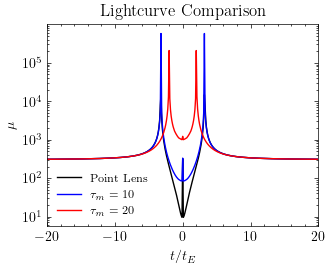

In [21]:
#compare lightcurve from boson star to that from point lens
plt.plot(timestamps, magnifications_pl, color = 'black', label = 'Point Lens')
plt.plot(timestamps, magnifications_tm_10, color = 'blue', label=r'$\tau_m = 10$')
plt.plot(timestamps, magnifications_tm_20, color = 'red', label=r'$\tau_m = 20$')
plt.xlabel(r'$t/t_E$')
plt.xlim(-20,20)
plt.ylabel(r'$\mu$')
plt.legend(loc='lower left', fontsize ='small')
plt.yscale('log')
plt.title(r'Lightcurve Comparison')
plt.savefig('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/figures/lightcurve_comparison.png', dpi=300, format='png')